# **Speech Feature Tutorial**

Speech is a very **high-dimensional** signal. For instance, when the sampling frequency is 16 kHz, we have 16000 samples for each second. Working with such very high dimensional data can be critical from a machine learning perspective. The goal of feature extraction is to find **more compact** ways to represent speech.

The study of proper speech features was a very active field for research some years ago. With the advent of deep learning, however, the trend is to feed neural networks with **simple features**. We then leave the network itself discovering higher-level representations.

In this tutorial, we will describe the two most popular speech features:

*   Filter Banks (FBANKs)
*   Mel-Frequency Cepstral Coefficients (MFCCs)

We will then mention common techniques to add context information.


## **1. Filter Banks (FBANKs)**
FBANKs are time-frequency representations computed by applying a **set of filters** to the spectrogram of a speech signal. Please, [take a look at this tutorial](https://colab.research.google.com/drive/1dCY2XHC6NiDA9mor3jd9H9w-XEcD3M4L?usp=sharing) for a detailed overview on Fourier transform and spectrograms. 

First of all, let's download some speech signals and install SpeechBrain:

In [ ]:
%%capture
!wget https://www.dropbox.com/s/u8qyvuyie2op286/spk1_snt1.wav
!pip install speechbrain

Let's now compute the spectrogram of a speech signal: 



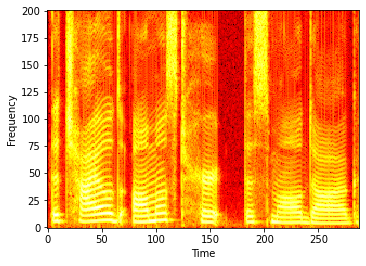

In [ ]:
import torch
import matplotlib.pyplot as plt
from speechbrain.dataio.dataio import read_audio
from speechbrain.processing.features import STFT

signal = read_audio('spk1_snt1.wav').unsqueeze(0) # [batch, time]

compute_STFT = STFT(sample_rate=16000, win_length=25, hop_length=10, n_fft=400)
signal_STFT = compute_STFT(signal)

spectrogram = signal_STFT.pow(2).sum(-1) # Power spectrogram
spectrogram = spectrogram.squeeze(0).transpose(0,1)
spectrogram = torch.log(spectrogram)

plt.imshow(spectrogram.squeeze(0), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

One way to compress the signal is to average the spectrogram over the frequency axis. This is done with a set of filters:

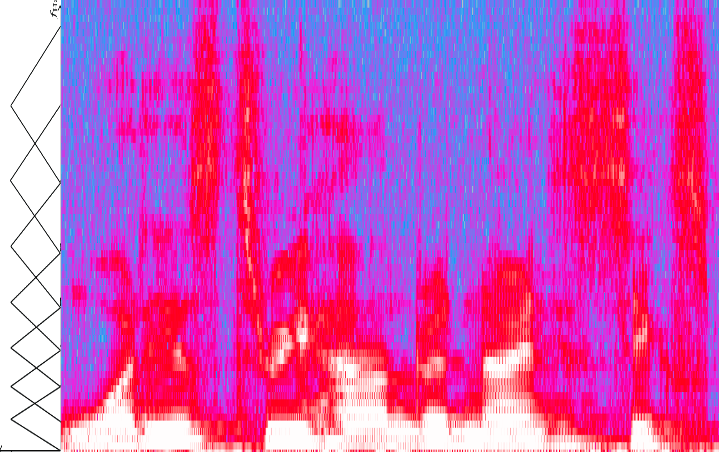

From the spectrogram, we can notice that most of the energy is concentrated in the **lower part of the spectrum**. It is convenient to allocate more filters in the lower part of the spectrum and fewer filters for high-frequency components.  This is what the mel filter banks are doing.

Each filter is **triangular** and has a response of 1 at the center frequency. The response decreases linearly towards 0 till it reaches the center frequencies of the two adjacent filters (see figure). There is thus some **overlap** between adjacent filters.

The filters are designed to be equally-spaced in the mel-frequency domain. It is possible to pass from the linear frequency domain to the mel one (and vice-versa) with the following non-linear transformations: 

$ m=2595log10(1+f/700)$

$f=700(10m/2595−1)$,

where $m$ is the mel frequency component and $f$ the standard frequency one (in Hz). The mel-frequency domain is compressed with a logarithm. The result is that filters equally spaced in the mel-domain will not be equally spaced in the target linear domain. We indeed have more filters in the lower part of the spectrum and less in the higher as desired.

Let's now compute FBANKs using SpeechBrain:

torch.Size([1, 288, 201, 2])
torch.Size([1, 288, 201])
torch.Size([1, 288, 40])


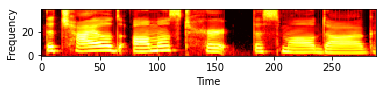

In [ ]:
from speechbrain.processing.features import spectral_magnitude
from speechbrain.processing.features import Filterbank

compute_fbanks = Filterbank(n_mels=40)

STFT = compute_STFT(signal)
mag = spectral_magnitude(STFT)
fbanks = compute_fbanks(mag)

print(STFT.shape)
print(mag.shape)
print(fbanks.shape)

plt.imshow(fbanks.squeeze(0).t(), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()


Normally, 40 or 80 FBANKs are computed. As you can observe from the shapes, the dimensionality of the time axis is the same. The dimensionality of the frequency axis, instead, has been reduced. You can see FBANKs just as a simple way to **compress** the rich information embedded in the spectrogram.

The SpeechBrain implementation of the filterbanks is designed to support different shapes of the filters (triangular, rectangular, gaussian). Moreover, when freeze=False, the filters are not frozen and can be tuned during training.

To make it easier the computation of FBANKs, we created a lobe that performs all the needed steps in a single function:

The SpeechBrain implementation of the filterbanks is designed to support different shapes for the filters (triangular, rectangular, gaussian). Morever, when `freeze=False`, the filters are not frozen and can be tuned during training.

To make it easier the computation of FBANKs, we created a lobe that performs all the needed steps in a single functions:



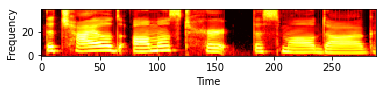

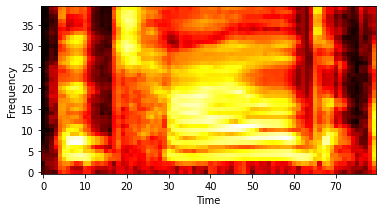

In [ ]:
from speechbrain.lobes.features import Fbank
fbank_maker = Fbank()
fbanks = fbank_maker(signal)

plt.imshow(fbanks.squeeze(0).t(), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

# Zoom of first 80 steps
plt.imshow(fbanks.squeeze(0).t()[:,0:80], cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

## **2. Mel-Frequency Cepstral Coefficients (MFCCs)**
MFCCs are computed by applying a Discrete Cosine Transform (DCT) on the top of the FBANKs. The DCT is a transformation that decorrelates the features and can be used to further compress them.

To make the computation of MFCCs easier, we created a lobe for that:


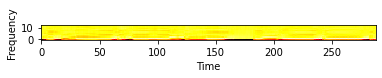

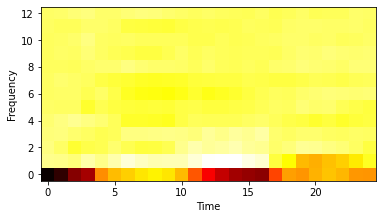

In [ ]:
from speechbrain.lobes.features import MFCC
mfcc_maker = MFCC(n_mfcc=13, deltas=False, context=False)
mfccs = mfcc_maker(signal)

plt.imshow(mfccs.squeeze(0).t(), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

#Zoom of the first 25 steps
plt.imshow(mfccs.squeeze(0).t()[:,0:25], cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In the past, working on decorrelated features was essential. Past machine learning techniques such as Gaussian Mixture Model (GMMS) were not suitable to model correlated data. Deep Neural networks, instead, can be work very well also with **correlated data** and FBANKs are nowadays the preferred choice.


## **3. Context Information**
Proper management of local context is essential to most speech processing tasks. The dominant solution in the past was about setting a “hand-crafted” context with the following approaches: 

*   Derivatives  
*   Context windows

### 3.1 Derivatives
The idea behind derivatives is to introduce a local context by simply computing the **difference** with adjacent features. The derivatives are often computed with MFCCS coefficients:

torch.Size([1, 288, 13])
torch.Size([1, 288, 39])


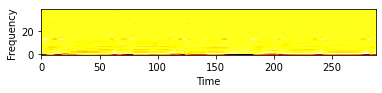

In [ ]:
from speechbrain.lobes.features import MFCC
mfcc_maker = MFCC(n_mfcc=13, deltas=True, context=False)
mfccs_with_deltas = mfcc_maker(signal)

print(mfccs.shape)
print(mfccs_with_deltas.shape)

plt.imshow(mfccs_with_deltas.squeeze(0).t(), cmap='hot', interpolation='nearest', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()


The first and second-order derivatives are called delta and delta-delta coefficients and are concatenated with the static coefficients. In the examples, the dimensionality is thus 39 (13 statics, 13 deltas, 13 delta-deltas).

### 3.2 Context Windows
Context windows adds a local context by simply **concatenating** multiple consecutive features. The result is a bigger feature vector that is better "aware" of the local information. 

Let's see an example:

In [ ]:
from speechbrain.lobes.features import MFCC
mfcc_maker = MFCC(n_mfcc=13, 
                  deltas=True, 
                  context=True,
                  left_frames=5, 
                  right_frames=5)
mfccs_with_context = mfcc_maker(signal)

print(mfccs.shape)
print(mfccs_with_deltas.shape)
print(mfccs_with_context.shape)

torch.Size([1, 288, 13])
torch.Size([1, 288, 39])
torch.Size([1, 288, 429])


In this case, we concatenate the current frame with 5 past and 5 future frames. The total dimesionality is thus $39 * (5+5+1)= 429$

Instead of using the aforementioned solutions, the current trend is to use static features and progressively add a **learnable context** through the **receptive field** on a **Convolutional Neural Network** (CNN). CNNs are often used in the early layers of the neural speech processing system to derive robust and context-aware representations.

## **4. Other Features**
A recent trend is to feed the neural network with the **raw data**. It is getting quite common to feed neural networks with the **spectrogram **directly or even with the **STFT**. It is also possible to feed the neural network with the **raw time-domain samples** directly. This is made easier with properly designed networks such as SincNEt. SincNEt uses a parametrized convolutional layers called SincConv that learns from the raw samples. SincNet is described in [this tutorial](add link). 

## **References**
[1] P. Mermelstein (1976), "Distance measures for speech recognition, psychological and instrumental," in Pattern Recognition and Artificial Intelligence. [ArXiv](http://www.haskins.yale.edu/sr/SR047/SR047_07.pdf)

[2] X. Huang, A. Acero (Author), H.-W. Hon, "Spoken Language Processing: A Guide to Theory, Algorithm and System Development Paperback – 2001

[3] https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

[4] M. Ravanelli, M. Omologo, "Automatic context window composition for distant speech recognition", Speech Communication, 2018 [ArXiv](https://arxiv.org/abs/1805.10498)

# **About SpeechBrain**
- Website: https://speechbrain.github.io/
- Code: https://github.com/speechbrain/speechbrain/
- HuggingFace: https://huggingface.co/speechbrain/


# **Citing SpeechBrain**
Please, cite SpeechBrain if you use it for your research or business.

```bibtex
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```